In [4]:
import numpy as np
from scipy.integrate import quad
from scipy.integrate import simpson
from scipy.special import erfinv

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

eps = 2*np.sqrt(np.finfo("float").eps)

In [5]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [6]:
def integral(y, x):
    return simpson(y, x, axis = 0)

In [7]:
def random_mat_cor(P):
    
    A = np.random.normal(size = (P, P))
    B = A @ A.T
    
    B = np.abs(B)
    D = np.diagonal(B)[np.newaxis]
    
    mat_cor = D.T**(-1/2) * B * D**(-1/2)
    
    return mat_cor

In [8]:
def random_mat_dom(P):
    
    A = np.random.normal(size = (P, P))
    B = A @ A.T
    
    B = np.abs(B)
    np.fill_diagonal(B, np.sum(B, axis = 0))
    
    D = np.diagonal(B)[np.newaxis]
    
    mat_dom = D.T**(-1/2) * B * D**(-1/2)
    
    return mat_dom

In [9]:
def simple_mat_cor(P, c):
    mat_cor = (1 - c) * np.eye(P, P) + c * np.ones((P, P))
    
    return mat_cor

In [10]:
def random_multivariate_binary(mat_cor, P, n_binary_samples):
    spins_x = np.sign(np.random.multivariate_normal(np.zeros(P), np.sin(np.pi/2 * mat_cor), n_binary_samples))
    # print(spins_x)
    # print(spins_x.reshape(1, -1, P, 1))
    
    # print(np.random.multivariate_normal(np.zeros(P), np.sin(np.pi/2 * mat_cor), n_binary_samples))
    
    return spins_x

In [278]:
class Iterator():
    def __init__(self, beta, alpha, mat_cor, P, n_normal_samples, n_binary_samples):
        self.mat_cor = mat_cor
        self.P = P
        
        spins_base = np.full((P, 2), np.array([-1, 1]))
        
        self.spins_s = np.array(np.meshgrid(*spins_base)).T.reshape(-1, 1, P, 1)
        self.spins_s_T = np.transpose(self.spins_s, axes = (0, 1, 3, 2))
        
        self.spins = self.spins_s.reshape(-1, 1, 1, P, 1)
        self.spins_T = self.spins_s_T.reshape(-1, 1, 1, 1, P)
        
        self.spins_u = self.spins_s.reshape(-1, 1, 1, 1, P, 1)
        self.spins_u_T = self.spins_s_T.reshape(-1, 1, 1, 1, 1, P)
        
        # self.z = np.linspace(-n_stds, n_stds, num = n_samples, endpoint = True).reshape(-1, 1, 1, 1, 1)
        
        # z_on_diag = z[..., np.newaxis]
        # z_off_diag = z[np.newaxis]
        
        # z = np.random.normal(size = (n_samples, P, P))
        z = np.random.normal(size = (n_normal_samples, 1, 1))
        z = np.full((n_normal_samples, P, P), z)
        self.z_on_diag = np.diagonal(z, axis1 = -2, axis2 = -1)[:, np.newaxis]
        # print(z.shape)
        # print(z_on_diag.shape)
        # print((np.eye(P, P) * z_on_diag).shape)
        self.z_off_diag = z - np.eye(P, P) * self.z_on_diag
        
        # (2**P, 1, P, 1)
        # (n_rademacher_samples, P, 1)
        
        spins_x = random_multivariate_binary(mat_cor, P, n_binary_samples).reshape(1, -1, P, 1)
        # print(spins_x)
        # print(spins_x)
        # print(spins_x.shape)
        # print(spins_s.shape)
        # print(self.spins_s == spins_x)
        # print((self.spins_s == spins_x).shape)
        
        self.p_x = np.mean(np.all(self.spins_s == spins_x, axis = 2, keepdims = True), axis = 1, keepdims = True)
        
        # print("p_x")
        # print(self.p_x.shape)
        # print("\n")
        
        self.update_params(beta, alpha)
    
    def update_params(self, beta, alpha):
        self.beta = beta
        self.alpha = alpha
        self.H_M = self.hamiltonian(self.beta, self.mat_cor)
        self.p_M = self.probability(self.H_M)
        # print("p_M")
        # print(self.p_M.shape)
        # print("\n")
    
    def action_eff(self, m, s, q_on_diag, q_off_diag, beta_eff):
        
        # print(s)
        
        # m = np.abs(m)
        # s = np.abs(s)
        # q_on_diag = np.abs(q_on_diag)
        # q_off_diag = np.abs(q_off_diag)
        
        q_sym = (q_off_diag + q_off_diag.T)/2
        q_sub = q_on_diag - np.sum(q_sym, axis = 1, keepdims = True)
        
        # print(q_sub)
        # print(q_sym)
        
        H_re = beta_eff * ((self.spins_T * self.z_on_diag) @ np.sqrt(np.maximum(q_sub, 0))
                           + (self.spins_u_T * self.z_on_diag) @ np.sqrt(np.maximum(q_sub, 0)))
        
        H_re = H_re + beta_eff * (self.spins_T @ np.sum(self.z_off_diag * np.sqrt(np.maximum(q_sym, 0)), axis = -1, keepdims = True)
                                  + self.spins_u_T @ np.sum(self.z_off_diag * np.sqrt(np.maximum(q_sym, 0)), axis = -1, keepdims = True))
        
        H_re = H_re + 1/2*beta_eff**2 * ((self.spins_T @ (s - q_sym) @ self.spins) + 2 * (self.spins_T @ m @ self.spins_s)
                                         + (self.spins_u_T @ (s - q_sym) @ self.spins_u) + 2 * (self.spins_u_T @ m @ self.spins_s))
        
        H_im = beta_eff * ((self.spins_T * self.z_on_diag) @ np.sqrt(np.maximum(-q_sub, 0))
                           - (self.spins_u_T * self.z_on_diag) @ np.sqrt(np.maximum(-q_sub, 0)))
        
        H_im = H_im + beta_eff * (self.spins_T @ np.sum(self.z_off_diag * np.sqrt(np.maximum(-q_sym, 0)), axis = -1, keepdims = True)
                                  - self.spins_u_T @ np.sum(self.z_off_diag * np.sqrt(np.maximum(-q_sym, 0)), axis = -1, keepdims = True))
        
        # print("H_im:")
        # print(np.min(H_im))
        # print(np.max(H_im))
        # print("H_re:")
        # print(np.min(H_re))
        # print(np.max(H_re))
        # raise NotImplementedError
        
        C = np.max(H_re, axis = 0)
        M_L = np.sum(np.cos(H_im) * np.exp(H_re - C), axis = 0)
        H_L = C + np.log(np.abs(M_L))
        
        H_cmp = beta_eff**2 * (self.spins_T @ self.spins_s) + beta_eff * np.sum(self.spins_T * self.z_on_diag, axis = -1, keepdims = True)
        
        # index = 3
        # print("H_L:")
        # print(np.squeeze(H_L[:, :, index]))
        # print("H_cmp:")
        # print(np.squeeze(H_cmp[:, :, index]))
        # print("H_diff:")
        # print(np.squeeze(H_cmp[:, :, 0 : index]) - np.squeeze(H_L[:, :, 0 : index]))
        
        # raise NotImplementedError
        
        M_L = np.sign(M_L)
        # print(np.sum(M_L, axis = 0))
        
        # H_L = H_L + 1/2*beta_eff**2 * (self.spins_T @ (s - q_sym) @ self.spins) + beta_eff**2 * (self.spins_T @ m @ self.spins_s)
        
        # H_L = H_L + beta_eff * ((self.spins_T * self.z_on_diag) @ np.sqrt(np.maximum(q_sub, 0)))
        
        # H_L = H_L + beta_eff * (self.spins_T @ np.sum(np.sqrt(np.maximum(q_sym, 0)) * self.z_off_diag, axis = -1, keepdims = True))
        
        ######
        
        # H_L = 1/2*beta_eff**2 * (self.spins_T @ (s - q_sym) @ self.spins) + beta_eff**2 * (self.spins_T @ m @ self.spins_s)
        
        # H_L = H_L + beta_eff * ((self.spins_T * self.z_on_diag) @ np.sqrt(q_sub.astype(np.complex64)))
        
        # H_L = H_L + beta_eff * (self.spins_T @ np.sum(np.sqrt(q_sym.astype(np.complex64)) * self.z_off_diag, axis = -1, keepdims = True))
        
        # M_L = 1
        
        return H_L, M_L
    
    # def Z_L(self, m, s, q_off_diag, q_on_diag, beta_eff):
        # return np.sum(np.exp(H_L(m, s, q_off_diag, q_on_diag, beta_eff)), axis = 0)
    
    def hamiltonian(self, beta_eff, mat_cor):
        return 1/2*beta_eff**2 * (self.spins_s_T @ mat_cor @ self.spins_s)
    
    def probability(self, H, M = 1):
        C = np.max(H, axis = 0)
        M = M * np.exp(H - C)
        return M / np.sum(M, axis = 0)
    
    def update(self, m, s, q):
        
        # q = (q + q.T)/2
        # m = (m + m.T)/2
        
        # print(q)
        
        q_on_diag = np.diagonal(q).copy()[:, np.newaxis]
        # print(q.shape)
        q_off_diag = q - np.eye(P, P) * q_on_diag
        
        s_no_diag = s - np.eye(P, P) * np.diagonal(s)[:, np.newaxis]
        
        H_L, M_L = self.action_eff(m, s_no_diag, q_on_diag, q_off_diag, self.beta)
        p_L = self.probability(H_L, M_L)
        
        # print("p_L")
        # print(p_L.shape)
        # print("\n")
        
        H_q = self.hamiltonian(self.beta, s_no_diag)
        p_q = self.probability(H_q)
        
        # print("p_q")
        # print(p_q.shape)
        # print("\n")
        
        # print((self.spins_s_T * self.spins_s).shape)
        # print(p_q.shape)
        
        # print(p_L.shape)
        # print(self.spins_T.shape)
        # print(self.spins.shape)
        
        # print("\n")
        
        # print(self.spins_s.shape)
        # print(np.sum(p_L * self.spins_T, axis = 0).shape)
        
        # print("\n")
        
        # print(self.p_M.shape)
        # print(np.mean(self.spins_s * np.sum(p_L * self.spins_T, axis = 0), axis = 1, keepdims = True).shape)
        
        # print("\n")
        # print("\n")
        
        m_hat = self.beta**2*self.alpha * np.squeeze(np.sum(self.p_M * np.mean(self.spins_s * np.sum(p_L * self.spins_T, axis = 0), axis = 1, keepdims = True), axis = 0))
        s_hat = self.beta**2*self.alpha * np.squeeze(np.sum(self.p_M * np.mean(np.sum(p_L * self.spins_T * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0) - np.sum(p_q * self.spins_s_T * self.spins_s, axis = 0))
        q_hat = self.beta**2*self.alpha * np.squeeze(np.sum(self.p_M * np.mean(np.sum(p_L * self.spins_T, axis = 0) * np.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        
        # h_cmp = self.beta**2 * np.swapaxes(self.spins_s, -1, -2) + self.beta * self.z_on_diag
        # print(self.spins_s.shape)
        # print(self.z_on_diag.shape)
        
        # index = 4
        
        # print("Numerical:")
        # print(np.sum(p_L * self.spins_T, axis = 0)[:, 0 : index, 0])
        # print("Analytical:")
        # print(np.tanh(h_cmp)[:, 0 : index, 0])
        # print("Difference:")
        # print(np.tanh(h_cmp)[:, 0 : index, 0] - np.sum(p_L * self.spins_T, axis = 0)[:, 0 : index, 0])
        
        m_test = self.beta**2 * self.alpha * np.mean(np.tanh(self.beta**2 + self.beta * self.z_on_diag))
        
        print("Numerical m_hat:")
        print(m_hat)
        
        print("Analytical m_hat:")
        print(m_test)
        
        q_test = self.beta**2 * self.alpha * np.mean(np.tanh(self.beta**2 + self.beta * self.z_on_diag)**2)
        
        print("Numerical q_hat:")
        print(q_hat)
        
        print("Analytical q_hat:")
        print(q_test)
        
        print("p_M:")
        print(self.p_M)
        
        raise NotImplementedError
        
        # print("m_hat:")
        # print(m_hat)
        # print("s_hat:")
        # print(s_hat)
        # print("q_hat:")
        # print(q_hat)
        
        q_hat_on_diag = np.diagonal(q_hat).copy()[:, np.newaxis]
        q_hat_off_diag = q_hat - np.eye(P, P) * q_hat_on_diag
        
        s_hat_no_diag = s_hat - np.eye(P, P) * np.diagonal(s_hat)[:, np.newaxis]
        
        H_L, M_L = self.action_eff(m_hat, s_hat_no_diag, q_hat_on_diag, q_hat_off_diag, 1)
        p_L = self.probability(H_L, M_L)
        # print(np.squeeze(p_L[:, :, 0]))
        # print(p_L.shape)
        
        m = np.squeeze(np.sum(self.p_x * np.mean(self.spins_s * np.sum(p_L * self.spins_T, axis = 0), axis = 1, keepdims = True), axis = 0))
        s = np.squeeze(np.sum(self.p_x * np.mean(np.sum(p_L * self.spins_T * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        q = np.squeeze(np.sum(self.p_x * np.mean(np.sum(p_L * self.spins_T, axis = 0) * np.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        
        # print("m:")
        # print(m)
        # print("s:")
        # print(s)
        # print("q:")
        # print(q)
        
        return m, s, q
    
    def iterate(self, m, s, q, t, store_state):
        
        m_list = []
        s_list = []
        q_list = []
        
        for _ in range(t):
            if store_state:
                m_list.append(m)
                s_list.append(s)
                q_list.append(q)
            
            m, s, q = self.update(m, s, q)
            s = np.identity(self.P)
            q = m # np.identity(self.P)
            # print(m)
            # print(s)
            # print(q)
        
        m_list.append(m)
        s_list.append(s)
        q_list.append(q)
        
        return m_list, s_list, q_list # m, s, q

In [279]:
n_normal_samples = 20000
n_binary_samples = 2000000

beta = 1.2
alpha = 1.8 # 0.48
P = 2
c = 0 # 0.7

mat_cor = simple_mat_cor(P, c)

iterator = Iterator(beta, alpha, mat_cor, P, n_normal_samples, n_binary_samples)

In [280]:
# Probe c = 0.1, 0.4, 0.7, 1
# or c = 0.1, 0.25, 0.4, 0.55, 0.7, 0.85, 1

t = 40

# m = -np.array([[0.32, -0.32], [-0.32, 0.32]])
# s = np.identity(P)
# q = np.array([[0.55, 0.1], [0.1, 0.55]])

m = np.identity(P) # random_mat_cor(P)
s = np.identity(P) # np.zeros((P, P)) # random_mat_cor(P)
q = np.identity(P) # np.zeros((P, P)) # random_mat_cor(P)

# s = s - np.eye(P, P) * np.diagonal(s)[:, np.newaxis]

m_list, s_list, q_list = iterator.iterate(m, s, q, t, store_state = True)

plt.plot(np.array(m_list).reshape(t+1, P**2))
plt.show()

plt.plot(np.array(s_list).reshape(t+1, P**2))
plt.show()

plt.plot(np.array(q_list).reshape(t+1, P**2))
plt.show()

Numerical m_hat:
[[ 1.73030475e+00 -1.43884904e-16]
 [-2.15827356e-16  1.73030475e+00]]
Analytical m_hat:
1.7180666009154963
Numerical q_hat:
[[1.72661216 0.41806209]
 [0.41806209 1.72661216]]
Analytical q_hat:
1.7247528734368573
p_M:
[[[[0.25]]]


 [[[0.25]]]


 [[[0.25]]]


 [[[0.25]]]]


NotImplementedError: 

In [89]:
np.sum(np.abs(np.array([[0.17961558, -0.07934133], [-0.05717576, 0.02639493]])))/2

0.1712638

In [92]:
2 * 0.33445382
# 0.669

2 * 0.307
# 0.614

2 * 0.1945
# 0.389

2 * 0.14521511
# 0.290

### 2 * 0.18385678

0.29043022

In [86]:
print(np.array(s_list))

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 1.          0.33030211  0.32906072]
  [ 0.33030211  1.          0.32996195]
  [ 0.32906072  0.32996195  1.        ]]

 [[ 1.         -0.27467325 -0.27542235]
  [-0.27467325  1.         -0.27486683]
  [-0.27542235 -0.27486683  1.        ]]

 [[ 1.          0.30880899  0.30770688]
  [ 0.30880899  1.          0.30850577]
  [ 0.30770688  0.30850577  1.        ]]

 [[ 1.         -0.27386718 -0.27416754]
  [-0.27386718  1.         -0.27393548]
  [-0.27416754 -0.27393548  1.        ]]

 [[ 1.          0.32579091  0.32464169]
  [ 0.32579091  1.          0.32546521]
  [ 0.32464169  0.32546521  1.        ]]

 [[ 1.         -0.28608728 -0.2862649 ]
  [-0.28608728  1.         -0.28611542]
  [-0.2862649  -0.28611542  1.        ]]

 [[ 1.          0.34107758  0.33944946]
  [ 0.34107758  1.          0.34061691]
  [ 0.33944946  0.34061691  1.        ]]

 [[ 1.         -0.307365

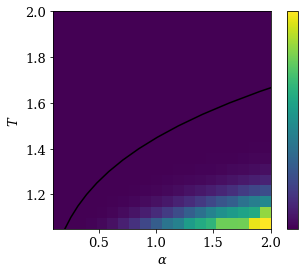

In [60]:
n_normal_samples = 20000
n_binary_samples = 200000
t = 10

n_beta = 20
n_alpha = 20

q_range = np.zeros((n_beta, n_alpha))
eigval_range = np.zeros(n_beta)

beta = 0
alpha = 0
P = 3
c = 0.7

mat_cor = simple_mat_cor(P, c)

iterator = Iterator(beta, alpha, mat_cor, P, n_normal_samples, n_binary_samples)

T_range = np.linspace(1.05, 2, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.1, 2, num = n_alpha, endpoint = True)
# T_range = np.linspace(1.2, 2, num = n_beta, endpoint = True)
# alpha_range = np.linspace(0.4, 2, num = n_alpha, endpoint = True)

m_init = random_mat_cor(P)
s_init = random_mat_cor(P)
q_init = random_mat_cor(P)

for i, T in enumerate(T_range):
    for j, alpha in enumerate(alpha_range):
        iterator.update_params(1/T, alpha)
        m, s, q = iterator.iterate(m_init, s_init, q_init, t, store_state = False)
        q_range[i, j] = np.mean(m)
    
    d = np.squeeze(np.sum(iterator.p_M * iterator.spins_s_T * iterator.spins_s, axis = 0))[0, 1]
    eigval = (P - 1)**2 * c*d + (P - 1) * (c + d) + 1
    eigval_range[i] = eigval

fontsize = 13

plt.imshow(q_range, aspect = 2, origin = "lower", cmap = "viridis",
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)))
plt.plot(T_range**4/eigval_range, T_range, color = "black")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar(ticks = [0, 1/2])
colorbar.ax.set_yticklabels([0, 1/2], fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"$\alpha$", fontsize = fontsize)
plt.ylabel(r"$T$", fontsize = fontsize)
plt.show()

In [47]:
print(T_range)
print(alpha_range)

[1.2 1.4 1.6 1.8 2. ]
[0.4 0.8 1.2 1.6 2. ]


[0.39287389 0.8493109  1.64159275 2.89457652 4.74702354]


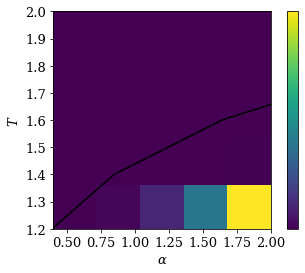

In [56]:
print(T_range**4/eigval_range)
plt.imshow(q_range, aspect = 2, origin = "lower", cmap = "viridis",
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)))
plt.plot(T_range**4/eigval_range, T_range, color = "black")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar(ticks = [0, 1/2])
colorbar.ax.set_yticklabels([0, 1/2], fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"$\alpha$", fontsize = fontsize)
plt.ylabel(r"$T$", fontsize = fontsize)
plt.show()

In [31]:
print(iterator.p_M.shape)
print(iterator.spins_s_T.shape)
print(iterator.spins_s.shape)

print(np.squeeze(np.sum(iterator.p_M * iterator.spins_s_T * iterator.spins_s, axis = 0)))

(8, 1, 1, 1)
(8, 1, 1, 3)
(8, 1, 3, 1)
[[1.         0.79428785 0.79428785]
 [0.79428785 1.         0.79428785]
 [0.79428785 0.79428785 1.        ]]


# $S = \beta^4 \alpha Q R$
# $\alpha_{\text{crit}} \leq \frac{1}{\beta^4 \lambda^S_{\text{max}}}$

### Plot unrelated probability distributions

In [12]:
def prob(x, p):
    return np.exp(-x**p)

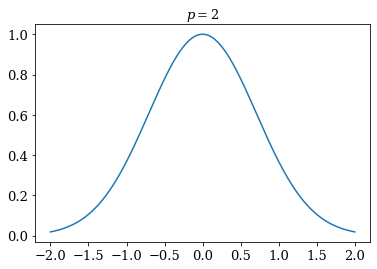

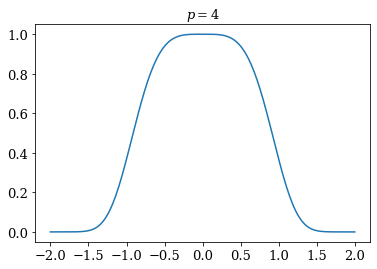

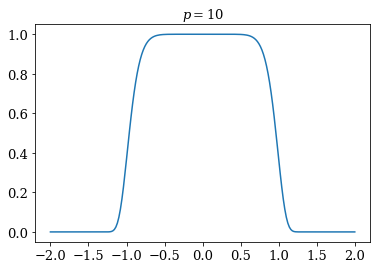

In [24]:
fontsize = 13

x = np.linspace(-2, 2, num = 201, endpoint = True)
p_range = np.array([2, 4, 10])

for p in p_range:
    plt.plot(x, prob(x, p))
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.title(r"$p = %d$" % p, fontsize = fontsize)
    plt.show()